In [9]:
# # pip install
# %pip install openai dill seaborn

In [6]:
# Corpus
# CORPUS = "synthetic_data_corpus"
# CORPUS_NAME = "converted_climate_change_gpt-4-turbo-preview_gpt-4-turbo-preview_10_10"
CORPUS_NAME = "dog_ownership"

# The name of the experiment (i.e. where to save the results)
# EXPERIMENT_NAME = "climate_synthetic_test_k2"
EXPERIMENT_NAME = "test_classifiers_ignore_me"

# CORPUS_SIZE = "/20_10"
CORPUS_SIZE = "voice"
# CORPUS_SIZE = "/N_20_K_10"


In [14]:
if CORPUS_SIZE == "voice":
    CORPUS = "/workspaces/dev/projects/narratives/classifiers/real_world_corpora/the_voice_the_voice_broad_keyscheck_4sep2023_filtered_chars150to1200_gpt-3.5-turbo-instruct_2_2 (1).json"
elif CORPUS_SIZE == "climate":
    CORPUS = "/workspaces/dev/projects/narratives/classifiers/real_world_corpora/with_jensen_garrett_abbott_climate_climate_change_pms_curie_2_-1.json"
else:
    CORPUS = (
        "../gpt-4-only-corpora/"
        + CORPUS_NAME
        + CORPUS_SIZE
        + ".json"
    )

In [24]:
# Multiprocessing with joblib
import os
import yaml
from tqdm.auto import tqdm


# # Load texts from corpora/{CORPUS}.json
# with open(os.path.join("../corpora", f"{CORPUS}.json"), "r") as f:
#     corpus_data = yaml.safe_load(f)


# # Load texts from corpora/{CORPUS}.json
# with open(os.path.join("../corpora", f"{CORPUS}.json"), "r") as f:
#     corpus_data = yaml.safe_load(f)

with open(CORPUS, "r") as f:
    corpus_data = yaml.safe_load(f)

if CORPUS_SIZE == "voice" or CORPUS_SIZE == "climate":
    # print(corpus_data)
    X = [text["text"] for text in corpus_data]
    y = [text["affiliation"] for text in corpus_data]

    # Counter({'Australian Labor Party': 561, 'Liberal Party of Australia': 95, 'Independent': 89, 'Australian Greens': 14, 'National Party of Australia': 10})
    left = ["Australian Labor Party", "Australian Greens"]
    right = ["Liberal Party of Australia", "National Party of Australia"]
    
    # Merge into "left" and "right" affiliations, dropping others
    y = ["left" if affiliation in left else "right" if affiliation in right else None for affiliation in y]
    X = [x for x, y in zip(X, y) if y is not None]
    y = [y for y in y if y is not None]
    print(len(X), len(y))
    
    # Drop any classes with less than 2 examples
    from collections import Counter

    counter = Counter(y)
    print(counter)
    X = [x for x, y in zip(X, y) if counter[y] > 1]
    y = [y for y in y if counter[y] > 1]
    print(len(X), len(y))
else:
    seeds = corpus_data["seeds"]
    distilled = corpus_data["distilled"]
    summarized = corpus_data["summarized"]
    names = corpus_data["names"]
    dataset = corpus_data["dataset"]

    # Convert the dataset to corpus data format
    corpus_data = []
    for seed_set in dataset:
        for a in seed_set["a_first"]["a"]:
            corpus_data.append({"text": a, "speakername": "a"})
        for b in seed_set["a_first"]["b"]:
            corpus_data.append({"text": b, "speakername": "b"})
        for a in seed_set["b_first"]["a"]:
            corpus_data.append({"text": a, "speakername": "a"})
        for b in seed_set["b_first"]["b"]:
            corpus_data.append({"text": b, "speakername": "b"})

    # Shuffle
    # random.shuffle(corpus_data)

    print("Loaded {} texts from corpus".format(len(corpus_data)))
    print("Total word count:", sum([len(text["text"].split()) for text in corpus_data]))

    # Create the training data
    X = [text["text"] for text in corpus_data]
    y = [text["speakername"] for text in corpus_data]
    print(len(X), len(y))

# print("Loaded {} texts from corpus".format(len(corpus_data)))
# print("Total word count:", sum([len(text["text"].split()) for text in corpus_data]))

# Create the training data and use an n-gram sklearn model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

# from sklearn.model_selection import train_test_split
# Stratified train-test split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

# Create the training data
# X = [text["text"] for text in corpus_data]
# y = [text["speakername"] for text in corpus_data]
# print(len(X), len(y))

print("Loaded {} texts from corpus".format(len(corpus_data)))
print("Total word count:", sum([len(text["text"].split()) for text in corpus_data]))

# Split into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

print(len(X_train), len(X_test), len(y_train), len(y_test))

# Create the pipeline
text_clf = Pipeline(
    [
        ("vect", CountVectorizer(ngram_range=(1, 2))),
        ("tfidf", TfidfTransformer()),
        # SGD classifier
        (
            "clf",
            SGDClassifier(
                # loss="hinge", # Probability weights not available
                loss="log_loss",
                penalty="l2",
                alpha=1e-3,
                random_state=42,
                max_iter=5,
                tol=None,
            ),
        ),
        # Naive Bayes
        # ('clf', MultinomialNB()),
    ]
)

# Fit the model
text_clf.fit(X_train, y_train)

# Predict
predicted = text_clf.predict(X_test)
probs = text_clf.predict_proba(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, predicted))
print("F1:", f1_score(y_test, predicted, average="weighted"))

# Cross validation
scores = cross_val_score(text_clf, X, y, cv=5)
print("Cross validation scores:", scores)
print("Cross validation mean:", scores.mean())
print("Cross validation std:", scores.std())

# Save the data in CSV format
import pandas as pd

# Make the folder
os.makedirs(f"corpus_results/classifiers/{EXPERIMENT_NAME}", exist_ok=True)

# Save the predictions for each datum in the test set to data.csv
df = pd.DataFrame(
    {
        "text": X_test,
        "truth": y_test,
        "classification": predicted,
        "a": [p[0] for p in probs],
        "b": [p[1] for p in probs],
    }
)
df.to_csv(f"corpus_results/classifiers/{EXPERIMENT_NAME}/data.csv")

680 680
Counter({'left': 575, 'right': 105})
680 680
Loaded 769 texts from corpus
Total word count: 83364
TRAIN: 544 TEST: 136
544 136 544 136
Accuracy: 0.8455882352941176
F1: 0.7748418092336536
Cross validation scores: [0.84558824 0.84558824 0.85294118 0.85294118 0.84558824]
Cross validation mean: 0.8485294117647058
Cross validation std: 0.0036021907982105436


In [26]:
import random

# %pip install seaborn
# Sample N=(10, 100, 500) texts for training set, 100 times each
N = [10, 20, 50, 100, 200, 500]
n_samples = 100
results = {}
min_class_size = float("Inf")
for speaker in set(y_train):
    min_class_size = min(min_class_size, len([y for y in y_train if y == speaker]))
print("Minimum class size:", min_class_size)

for n in tqdm(N):
    # if n > len(X_train)
    if n > min_class_size:
        continue

    results[n] = []
    for iteration in tqdm(range(n_samples)):
        # Sample n texts from X_train
        # X_train_sample = random.sample(X_train, n)
        # y_train_sample = [y_train[X_train.index(text)] for text in X_train_sample]

        # Sample stratified, N/2 for each class
        X_train_sample = []
        y_train_sample = []
        for speaker in set(y_train):
            X_train_sample.extend(
                random.sample(
                    [
                        text
                        for text, speakername in zip(X_train, y_train)
                        if speakername == speaker
                    ],
                    n // 2,
                )
            )
            y_train_sample.extend([speaker for _ in range(n // 2)])

        # Shuffle together
        X_train_sample, y_train_sample = zip(
            *random.sample(
                list(zip(X_train_sample, y_train_sample)), len(X_train_sample)
            )
        )

        # print(X_train_sample)
        # print(y_train_sample)

        # print(len(X_train_sample), len(y_train_sample))

        # Clear the model
        text_clf = Pipeline(
            [
                ("vect", CountVectorizer(ngram_range=(1, 2))),
                ("tfidf", TfidfTransformer()),
                # SGD classifier
                # ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                # Probability estimates not available for loss='hinge'
                (
                    "clf",
                    SGDClassifier(
                        loss="log_loss",
                        penalty="l2",
                        alpha=1e-3,
                        random_state=42,
                        max_iter=5,
                        tol=None,
                    ),
                ),
                # Naive Bayes
                # ('clf', MultinomialNB()),
            ]
        )
        # Fit the model
        text_clf.fit(X_train_sample, y_train_sample)
        # Predict
        predicted = text_clf.predict(X_test)
        probs = text_clf.predict_proba(X_test)
        # Evaluate
        results[n].append(
            {
                "n": n,
                "i": iteration,
                "accuracy": accuracy_score(y_test, predicted),
                "predictions": predicted,
                "probabilities": probs,
            }
        )

Minimum class size: 84


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# Save each prediction to a CSV, flattened and including the value of n and the iteration as columns
df = pd.concat(
    [
        pd.DataFrame(
            {
                "n": n,
                "i": iteration,
                "text": X_test,
                # "accuracy": result["accuracy"],
                "truth": y_test,
                "classification": result["predictions"],
                "a": [p[0] for p in result["probabilities"]],
                "b": [p[1] for p in result["probabilities"]],
            }
        )
        for n, results_n in results.items()
        for iteration, result in enumerate(results_n)
    ]
)

# Save to CSV without index
df.to_csv(f"corpus_results/classifiers/{EXPERIMENT_NAME}/data_sampled.csv", index=False)

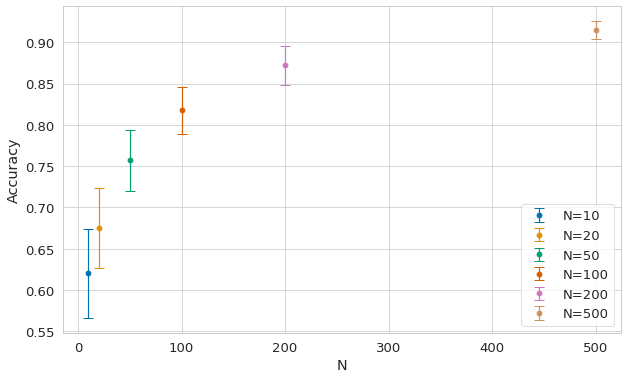

In [18]:
# %pip install seaborn
# Show results
# print(results)

# # Save the data in JSON format
# import json
# with open(f"corpus_results/{EXPERIMENT_NAME}.json", "w") as f:
#     json.dump(results, f)

# Save the results
df = pd.DataFrame(results)
df.to_csv(f"corpus_results/classifiers/{EXPERIMENT_NAME}/scores.csv")

# Show average and std for each N
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 6))

for n in N:
    if n in results:
        plt.errorbar(
            n,
            np.mean([result["accuracy"] for result in results[n]]),
            yerr=np.std([result["accuracy"] for result in results[n]]),
            fmt="o",
            capsize=5,
            label=f"N={n}",
        )

# Give solid white background
plt.gca().set_facecolor("white")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(
    f"corpus_results/classifiers/{EXPERIMENT_NAME}/accuracy.jpg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()